In [ ]:
# Utility Libraries
import numpy as np
import pandas as pd
import sys
import time
import random
from scipy import linalg
import cv2
import string
from PIL import Image, ImageDraw
from PIL.Image import fromarray
import os
import re

# Pytorch relevant libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import cat
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torchvision import datasets, transforms, models
from torchvision import transforms as T
from torchvision.models import inception_v3
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import random_split

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.manifold import TSNE

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [ ]:
dataset = datasets.ImageFolder(root='/kaggle/input/satellite-image-classification/data', transform=transform)

In [ ]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
def get_image_by_class(class_label, dataloader):
    for images, labels in dataloader:
        for i in range(len(labels)):
            if labels[i] == class_label:
                image = images[i]
                return image

In [ ]:
class_names = [
    'Cloudy',
    'Desert',
    'Green Area',
    'Water'
]

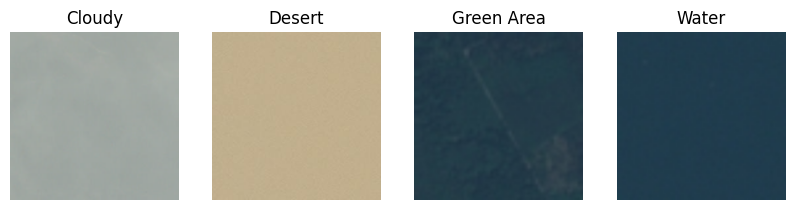

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(10, 40))

for class_idx in range(4):
    image = get_image_by_class(class_idx, train_loader)
    ax[class_idx].imshow(image.permute(1, 2, 0))
    ax[class_idx].axis('off')
    ax[class_idx].set_title(class_names[class_idx])

plt.show()

---
# Part 1: Training only the last layer
---

In [ ]:
class EfficientNet_b4(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNet_b4, self).__init__()
        self.effnet_b4 = models.efficientnet_b4(pretrained=pretrained)

        # Removing the last layer
        self.effnet_b4 = nn.Sequential(*list(self.effnet_b4.children())[:-1])

    def forward(self, x):
        x = self.effnet_b4(x)
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return x

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        self.effnet_b4 = EfficientNet_b4(pretrained)
        if pretrained:
            # Freeze the parameters
            for param in self.effnet_b4.parameters():
                param.requires_grad = False

        self.fc = nn.Linear(1792, 4)

    def forward(self, x):
        x = self.effnet_b4(x)
        x = F.softmax(self.fc(x), dim=1)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, optimizer, criterion, epochs):
    start_time = time.time()
    train_loss_traj = []
    val_loss_traj = []
    train_acc_traj = []
    val_acc_traj = []

    avg_epoch_time = 0

    for epoch in range(epochs):
        epoch_train_loss = []
        epoch_val_loss = []
        correct_train = 0
        total_train = 0
        correct_val = 0
        total_val = 0

        # Training phase
        model.train()
        for images, labels in train_loader:
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            y_hat = model(images)

            loss = criterion(y_hat, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss.append(loss.item())

            _, predicted_train = torch.max(y_hat.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_loss = np.mean(epoch_train_loss)
        train_accuracy = correct_train / total_train
        train_acc_traj.append(train_accuracy)

        # Validation phase
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                torch.cuda.empty_cache()
                images, labels = images.to(device), labels.to(device)
                y_hat = model(images)

                val_loss = criterion(y_hat, labels)
                epoch_val_loss.append(val_loss.item())

                _, predicted_val = torch.max(y_hat.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_loss = np.mean(epoch_val_loss)
        val_accuracy = correct_val / total_val
        val_acc_traj.append(val_accuracy)

        train_loss_traj.append(train_loss)
        val_loss_traj.append(val_loss)

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, '
              f',Val Acc: {val_accuracy:.4f}')

        avg_epoch_time += time.time() - start_time
        start_time = time.time()

    print(f'Average time per epoch : {avg_epoch_time / epochs}')

    return model, train_loss_traj, val_loss_traj, train_acc_traj, val_acc_traj

In [ ]:
torch.cuda.empty_cache()

model = ConvNet(pretrained=True).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

model, train_loss_traj, val_loss_traj, train_acc_traj, val_acc_traj = train_model(model, optimizer, criterion, epochs)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 96.0MB/s]


Epoch 1/10, Train Loss: 1.1178, Train Acc: 0.9272, Val Loss: 0.9682, ,Val Acc: 0.9609
Epoch 2/10, Train Loss: 0.8795, Train Acc: 0.9741, Val Loss: 0.8301, ,Val Acc: 0.9810
Epoch 3/10, Train Loss: 0.8243, Train Acc: 0.9830, Val Loss: 0.8024, ,Val Acc: 0.9846
Epoch 4/10, Train Loss: 0.8046, Train Acc: 0.9863, Val Loss: 0.7880, ,Val Acc: 0.9858
Epoch 5/10, Train Loss: 0.7931, Train Acc: 0.9881, Val Loss: 0.7804, ,Val Acc: 0.9893
Epoch 6/10, Train Loss: 0.7835, Train Acc: 0.9899, Val Loss: 0.7749, ,Val Acc: 0.9905
Epoch 7/10, Train Loss: 0.7777, Train Acc: 0.9929, Val Loss: 0.7716, ,Val Acc: 0.9870
Epoch 8/10, Train Loss: 0.7732, Train Acc: 0.9934, Val Loss: 0.7698, ,Val Acc: 0.9870
Epoch 9/10, Train Loss: 0.7711, Train Acc: 0.9926, Val Loss: 0.7666, ,Val Acc: 0.9905
Epoch 10/10, Train Loss: 0.7692, Train Acc: 0.9921, Val Loss: 0.7683, ,Val Acc: 0.9905
Average time per epoch : 30.930900478363036


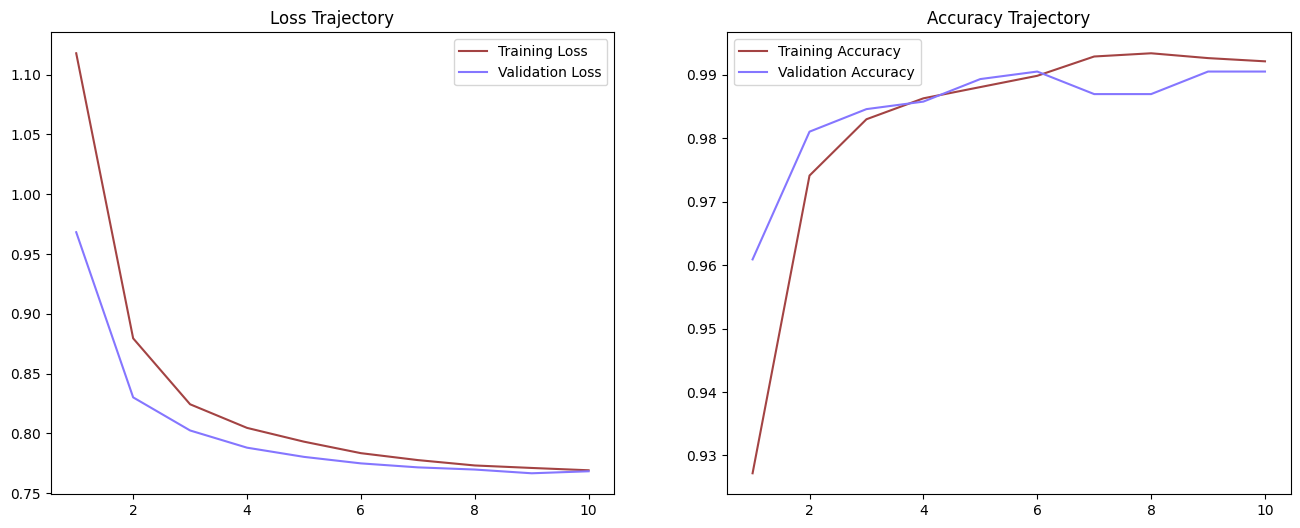

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

x_axis = range(1, 11, 1)
ax[0].plot(x_axis, train_loss_traj, label='Training Loss', color='#A34343')
ax[0].plot(x_axis, val_loss_traj, label='Validation Loss', color='#8576FF')
ax[0].set_title('Loss Trajectory')
ax[0].legend()

ax[1].plot(x_axis, train_acc_traj, label='Training Accuracy', color='#A34343')
ax[1].plot(x_axis, val_acc_traj, label='Validation Accuracy', color='#8576FF')
ax[1].set_title('Accuracy Trajectory')
ax[1].legend()

plt.show()

In [ ]:
def test_model(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average="macro")
    recall = recall_score(true_labels, predicted_labels, average="macro")
    precision = precision_score(true_labels, predicted_labels, average="macro")

    print(f"Testing Accuracy: {accuracy:.4f}")
    print(f"Testing F1 Score: {f1:.4f}")
    print(f"Testing Recall: {recall:.4f}")
    print(f"Testing Precision: {precision:.4f}")

In [ ]:
test_model(model)

Testing Accuracy: 0.9929
Testing F1 Score: 0.9931
Testing Recall: 0.9934
Testing Precision: 0.9927


---
# Part 2: Saliency map
---

In [ ]:
def generate_saliency_map(model, image, target_class):
    transform = transforms.Compose([
        T.Lambda(lambda x: x[None])
    ])

    image = transform(image)
    image.requires_grad_()

    y_hat = model(image)
    max_score = y_hat[0, y_hat.argmax()]
    max_score.backward()

    saliency_map, _ = torch.max(image.grad.data.abs(), dim=1)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(image[0].detach().cpu().permute(1, 2, 0))
    ax[0].set_title(f'Class : {class_names[target_class]}')
    ax[0].axis('off')

    ax[1].imshow(saliency_map[0].cpu().detach(), cmap='jet')
    ax[1].set_title('Saliency map')
    ax[1].axis('off')

    plt.show()

In [ ]:
# Since this model was trained with pretrained = True so this is fine tuned model
fine_tuned_model = model

In [ ]:
fine_tuned_model = fine_tuned_model.cpu()

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Training the entire network

In [ ]:
torch.cuda.empty_cache()

model = ConvNet(pretrained=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

model, train_loss_traj, val_loss_traj, train_acc_traj, val_acc_traj = train_model(model, optimizer, criterion, epochs)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 1.3911, Train Acc: 0.2608, Val Loss: 1.3999, ,Val Acc: 0.2773
Epoch 2/10, Train Loss: 1.3853, Train Acc: 0.2644, Val Loss: 1.4789, ,Val Acc: 0.1884
Epoch 3/10, Train Loss: 1.3840, Train Acc: 0.2647, Val Loss: 1.5790, ,Val Acc: 0.0877
Epoch 4/10, Train Loss: 1.3838, Train Acc: 0.2636, Val Loss: 1.4531, ,Val Acc: 0.1967
Epoch 5/10, Train Loss: 1.3842, Train Acc: 0.2581, Val Loss: 1.3016, ,Val Acc: 0.3993
Epoch 6/10, Train Loss: 1.3842, Train Acc: 0.2700, Val Loss: 1.3795, ,Val Acc: 0.2725
Epoch 7/10, Train Loss: 1.3835, Train Acc: 0.2649, Val Loss: 1.4051, ,Val Acc: 0.2690
Epoch 8/10, Train Loss: 1.3840, Train Acc: 0.2543, Val Loss: 1.2896, ,Val Acc: 0.4727
Epoch 9/10, Train Loss: 1.3839, Train Acc: 0.2710, Val Loss: 1.4331, ,Val Acc: 0.1943
Epoch 10/10, Train Loss: 1.3837, Train Acc: 0.2649, Val Loss: 1.4345, ,Val Acc: 0.2559
Average time per epoch : 324.8339174032211


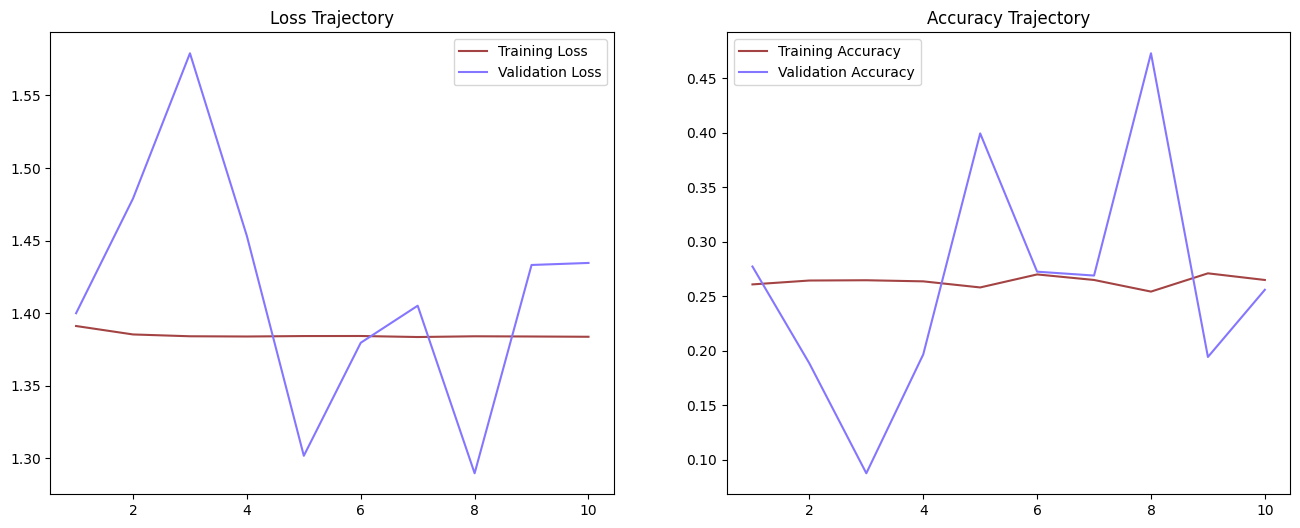

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

x_axis = range(1, 11, 1)
ax[0].plot(x_axis, train_loss_traj, label='Training Loss', color='#A34343')
ax[0].plot(x_axis, val_loss_traj, label='Validation Loss', color='#8576FF')
ax[0].set_title('Loss Trajectory')
ax[0].legend()

ax[1].plot(x_axis, train_acc_traj, label='Training Accuracy', color='#A34343')
ax[1].plot(x_axis, val_acc_traj, label='Validation Accuracy', color='#8576FF')
ax[1].set_title('Accuracy Trajectory')
ax[1].legend()

plt.show()

In [ ]:
test_model(model)

Testing Accuracy: 0.2423
Testing F1 Score: 0.1309
Testing Recall: 0.2364
Testing Precision: 0.1906


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = model.cpu()

In [ ]:
images = [get_image_by_class(i, train_loader) for i in range(4)]

## Saliency map for fine tuned model

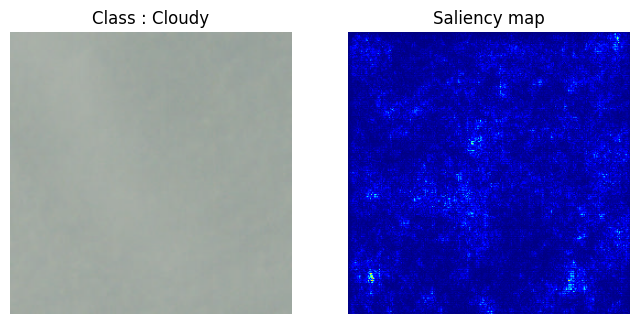

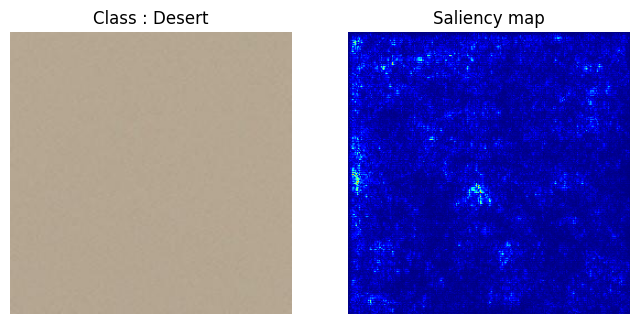

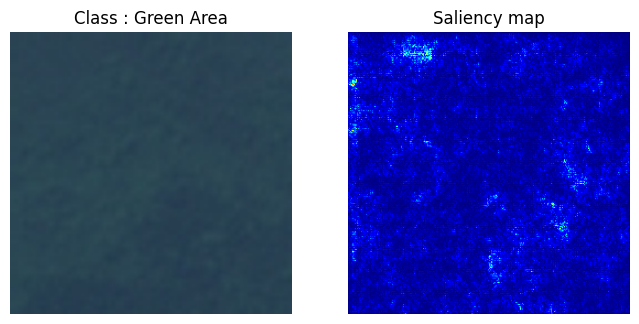

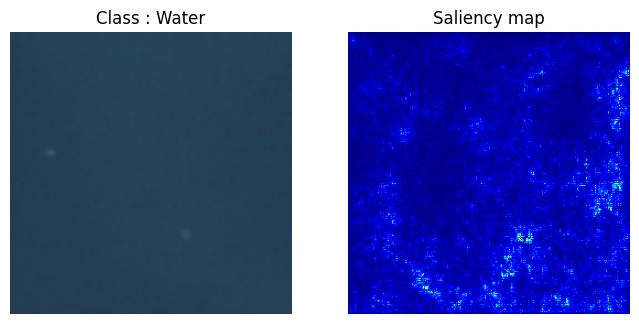

In [ ]:
for image, target_class in zip(images, range(4)):
    saliency_map = generate_saliency_map(fine_tuned_model, image, target_class)

## Saliency map for model trained on entire network

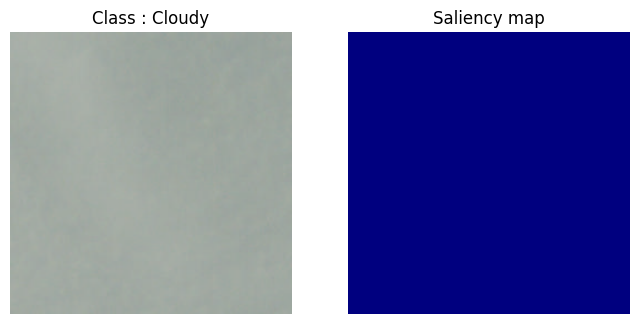

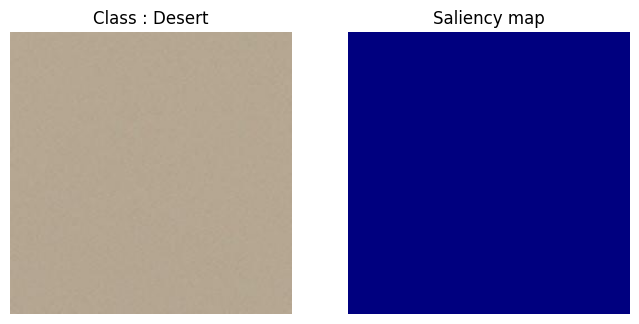

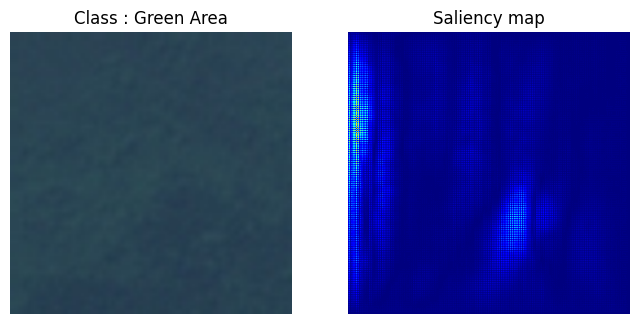

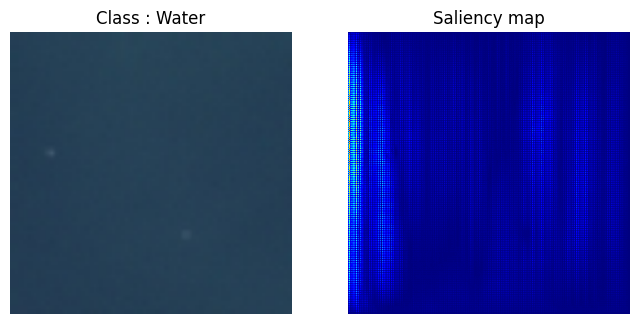

In [ ]:
for image, target_class in zip(images, range(4)):
    saliency_map = generate_saliency_map(model, image, target_class)

---
# Part 3: Finetuned v/s original network
---

Both the fine tuned model and original network were trained for 10 epochs and the following results were obtained:

1. The finetuned model achieved an validation accuracy of 96% in the 1st epoch itself, while the original network even after 10 epochs, couldn't acheive even 50% accuracy in any of the epochs. This was because the fine tuned model was trained to generate good salient features which were very useful to capture the actual essence of the input data, only thing the last layer had to learn was to convert the salient feature map to desirable classes which was way easier than the training the entire network as in the later case, we also had to learn the feature representation which would take more epochs to converge.
2. The convergence was very smooth in the case of finetuned model, whereas the training was highly unstable in the case of original network, which is evident from the loss curves.
3. Since, less number of parameters had to be learnt the fine tuned model was 10 times faster on an average as compared to the original network.
4. The fine tuned model had an testing f1-score of 99.31% which shows how well it can perform on diverse datasets.